In [1]:
import shap
import matplotlib.pyplot as plt
import numpy as np
print("Done")

/home/saron/MySpace/AI/kifya/week8/Fraud_Detection/notebooks/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done


In [3]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# Load processed data
ecom_data = pd.read_csv('../data/processed/feature_engineered_Fraud_Data.csv')

# Split features and target
X_ecom = ecom_data.drop('class', axis=1)
y_ecom = ecom_data['class']

# Train-test split
X_train_ecom, X_test_ecom, y_train_ecom, y_test_ecom = train_test_split(
    X_ecom, y_ecom, test_size=0.2, stratify=y_ecom, random_state=42)

# Define transformers
num_features = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day']
cat_features = ['source', 'browser', 'sex', 'country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Apply transformations
X_train_ecom_transformed = preprocessor.fit_transform(X_train_ecom)
X_test_ecom_transformed = preprocessor.transform(X_test_ecom)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_ecom_res, y_train_ecom_res = smote.fit_resample(X_train_ecom_transformed, y_train_ecom)

# Train XGBoost
xgb_ecom = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss')
xgb_ecom.fit(X_train_ecom_res, y_train_ecom_res)
print("Done")

/home/saron/MySpace/AI/kifya/week8/Fraud_Detection/notebooks/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:49:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done


In [5]:
# Convert to dense matrix for SHAP
X_train_ecom_dense = X_train_ecom_transformed.toarray()
X_test_ecom_dense = X_test_ecom_transformed.toarray()
print("done")

done


In [8]:
# TreeExplainer is ideal for XGBoost
explainer = shap.Explainer(xgb_ecom, X_train_ecom_dense)
print("Done")

Done


In [9]:
shap_values = explainer(X_test_ecom_dense)
print("done")

 98%|===================| 29476/30223 [00:13<00:00]        

done


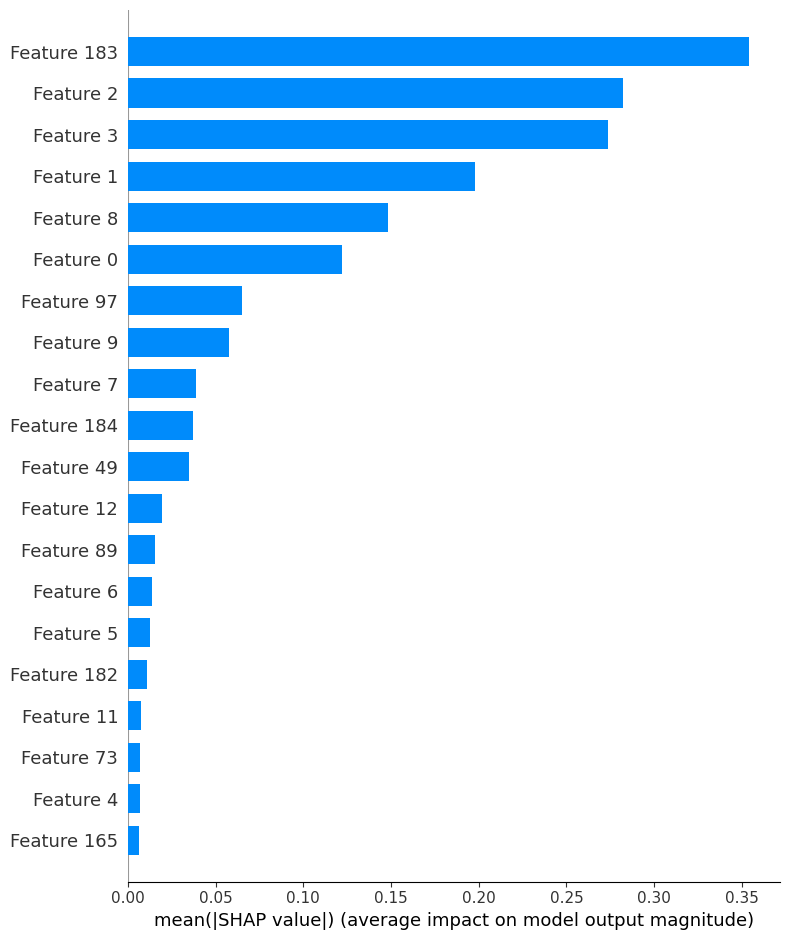

In [10]:
shap.summary_plot(shap_values, X_test_ecom_dense, plot_type="bar")


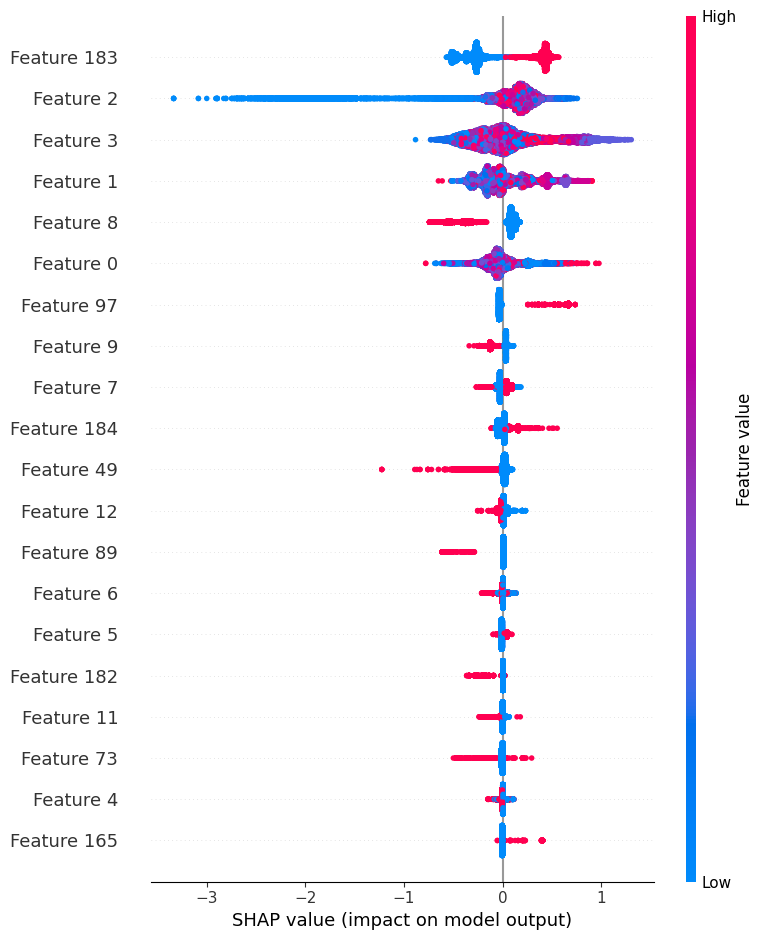

In [11]:
shap.summary_plot(shap_values, X_test_ecom_dense)


In [13]:
shap.initjs()


In [14]:
i = 5  # e.g., the 6th test instance
shap.plots.force(shap_values[i])


In [15]:
from IPython.display import display
display(shap.plots.force(shap_values[i]))


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Example pipeline
ecom_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])


In [20]:
# Get the feature names from the ColumnTransformer
from sklearn.compose import ColumnTransformer

# Only if your preprocessor is a ColumnTransformer
feature_names = preprocessor.get_feature_names_out()


In [21]:
X_test_ecom_dense_df = pd.DataFrame(X_test_ecom_dense, columns=feature_names)


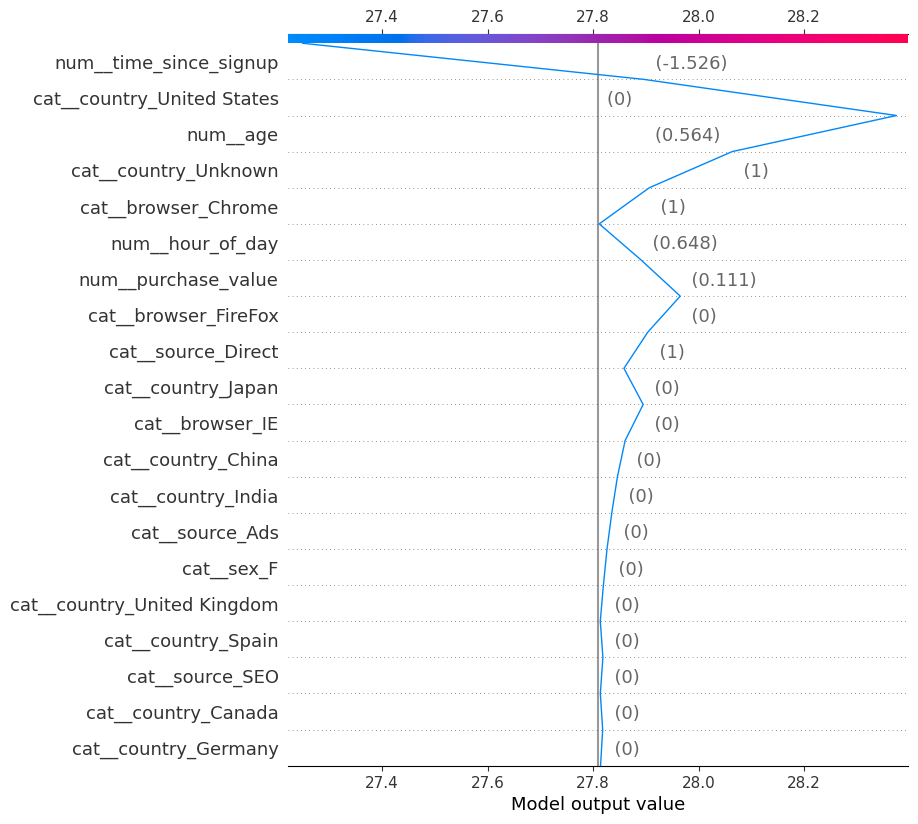

In [22]:
shap.decision_plot(explainer.expected_value, shap_values[i].values, X_test_ecom_dense_df.iloc[i])


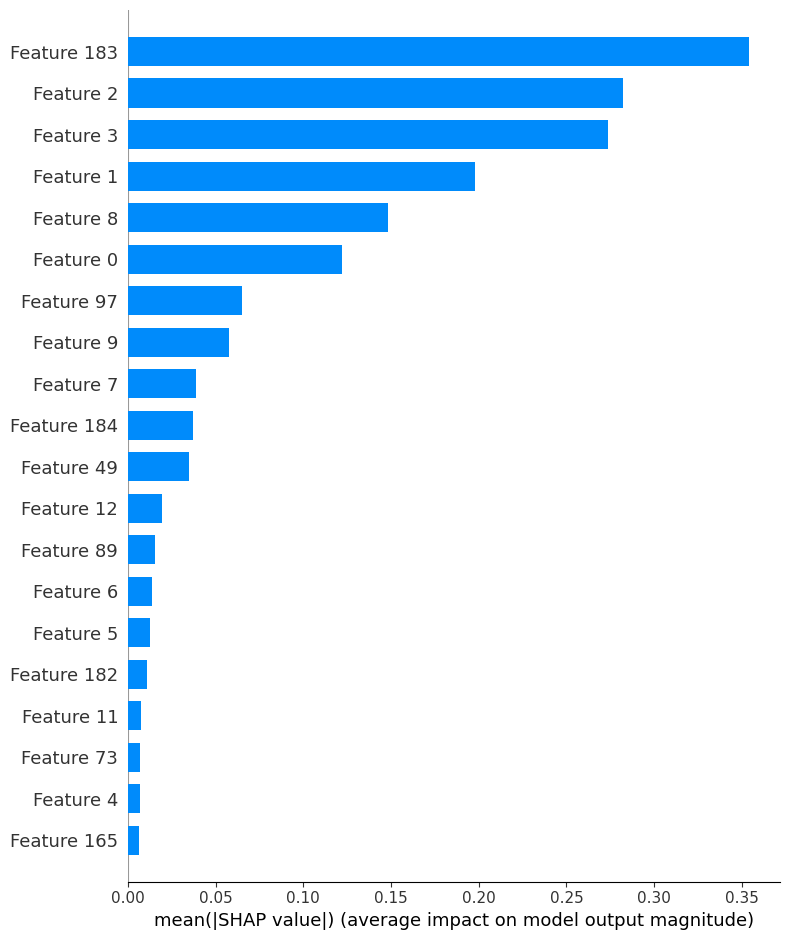

In [23]:
import matplotlib.pyplot as plt
plt.figure()
shap.summary_plot(shap_values, X_test_ecom_dense, plot_type="bar", show=False)
plt.savefig('../reports/figures/shap_summary_bar_ecom.png')
